In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'test', 'train.csv', 'sample_submission.csv']


In [2]:
train_idx=pd.read_csv('../input/train.csv')
HEIGH=512#image.shape[1]
WIDTH=512#image.shape[2]
CHANEL=1#image.shape[3]
print(train_idx.shape)
print(train_idx[0:5])
#we treat this like unet arquitect and like a mask we replace target to 0 to 27 outputs from 0 to 1 values
NUM_CLASSES=28
y_df=[[int(i) for i in s.split()] for s in train_idx['Target']]



y_df_final=np.zeros((train_idx.shape[0],NUM_CLASSES)).astype(int)

for i,x in enumerate(y_df):
    for val in x:
        #print(x,val,i)    
        y_df_final[i,val]=1
print(y_df_final[1])   
print(y_df_final.shape)

(31072, 2)
                                     Id   Target
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18
[1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(31072, 28)


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_idx, y_df_final, test_size=0.08, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(28586, 2)
(2486, 2)
(28586, 28)
(2486, 28)


Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


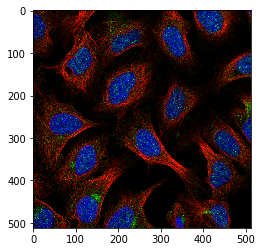

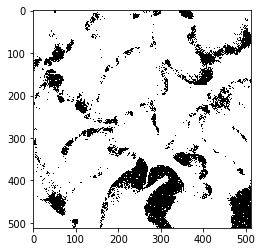

In [4]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img#,save_img
import matplotlib.pyplot as plt
from skimage import util

def open_rgb(path):
    name="../input/train/{}_green.png".format(path)
    G=(np.array(load_img(name, grayscale=True))) 
    name="../input/train/{}_blue.png".format(path)
    B=(np.array(load_img(name, grayscale=True))) 
    #name="../input/train/{}_yellow.png".format(np.squeeze(Xdata_set[idx]))
    #Y=downsample(np.array(load_img(name, grayscale=True))) / 255
    name="../input/train/{}_red.png".format(path)
    R=(np.array(load_img(name, grayscale=True))) 
    image=np.concatenate((R.reshape(HEIGH,WIDTH,1),G.reshape(HEIGH,WIDTH,1),B.reshape(HEIGH,WIDTH,1)),axis=2)                    
    return np.array(image,dtype="uint8")

def get_mask(im):
    image = np.zeros((HEIGH,WIDTH,3), dtype="uint8")    
    image[np.where((im==[0,0,0]).all(axis=2))] = [255,255,255]
    image=util.invert((image))    
    return image

im=open_rgb(train_idx.values[12][0])    
mask=get_mask(im)

plt.imshow(im)
plt.show()

plt.imshow(mask)
plt.show()

In [5]:
def keras_genereatorv1(Xdata_set,batch_size):
      while True:
            random_indexes = np.random.choice(len(Xdata_set), batch_size)
            batch_images = np.empty((batch_size, HEIGH, WIDTH, 3))
            #batch_mask = np.empty((batch_size, HEIGH, WIDTH, 3))
            #batch_labels = np.zeros((batch_size, 28))
        
            for x in range(batch_size):            
                for i, idx in enumerate(random_indexes):
                    image=open_rgb(Xdata_set.values[idx][0])
                    #mask=get_mask(image)
                    batch_images[i] =image/255
             #       batch_mask[i] =mask/255
                    #batch_labels[i]=ydata_set[idx]
            yield batch_images,batch_images
            
#X,Y=next(keras_genereatorv1(X_train,10))
#print(X.shape)

In [7]:
#we have generator now let go with autoencoder
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(HEIGH, WIDTH, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same',name="encode")(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
x = Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation=None, padding='same')(x)


encoder= Model(input_img,encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')
encoder.summary()
autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 512, 512, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 256, 256, 16)      4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 8)       1160      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 8)         0         
__________

In [8]:
autoencoder.fit_generator(keras_genereatorv1(X_train,10),steps_per_epoch=50,epochs=15,verbose=1,
                          validation_data=next(keras_genereatorv1(X_test,10)), validation_steps=10
                         )

Epoch 1/15
50/50 [==============================] - 220s 4s/step - loss: 0.0172 - val_loss: 0.0157
Epoch 2/15
50/50 [==============================] - 125s 2s/step - loss: 0.0149 - val_loss: 0.0136
Epoch 3/15
50/50 [==============================] - 130s 3s/step - loss: 0.0140 - val_loss: 0.0176
Epoch 4/15
50/50 [==============================] - 116s 2s/step - loss: 0.0130 - val_loss: 0.0136
Epoch 5/15
50/50 [==============================] - 113s 2s/step - loss: 0.0127 - val_loss: 0.0118
Epoch 6/15
50/50 [==============================] - 96s 2s/step - loss: 0.0131 - val_loss: 0.0134
Epoch 7/15
13/50 [======>.......................] - ETA: 1:31 - loss: 0.0127

KeyboardInterrupt: 

In [9]:
X,Y=next(keras_genereatorv1(X_train,10))
print(X.shape)

(10, 512, 512, 3)


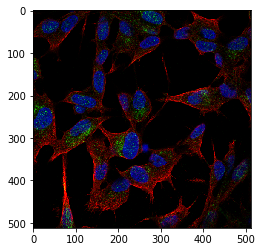

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


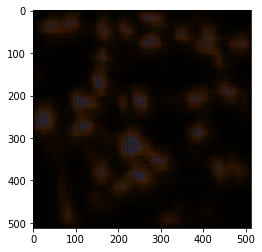

(32, 32, 4)


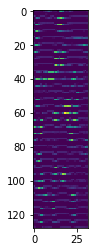

In [11]:

decoded_imgs = autoencoder.predict(X)
encoded_imgs = encoder.predict(X)


plt.imshow(X[0])
plt.show()    

plt.imshow(decoded_imgs[0])
plt.show()

print(encoded_imgs[0].shape)
plt.imshow(encoded_imgs[0].reshape(32,32*4).T)
plt.show()

In [12]:
h=encoded_imgs[0].shape[0]
w=encoded_imgs[0].shape[1]
c=encoded_imgs[0].shape[2]

In [14]:
#If we are lucky! we can load full train image on memory... if not we neet create a file load generator but slow train process..
#let go to train
train_len=len(X_train)
#train_len=10000


X_compresed=np.empty((train_len,encoded_imgs[0].shape[0],encoded_imgs[0].shape[1],encoded_imgs[0].shape[2]))



for x in range(train_len): 
   # print(x)
    X=np.empty((1,HEIGH, WIDTH, 3))
    X[0]=open_rgb(X_train.values[x][0])
    X_compresed[x]=encoder.predict(X)[0]
    
 
    
    
print(X_compresed.shape)



(28586, 32, 32, 4)


NameError: name 'X_compresed_test' is not defined

In [15]:

test_len=len(X_test)
#test_len=1000

X_compresed_test=np.empty((test_len,encoded_imgs[0].shape[0],encoded_imgs[0].shape[1],encoded_imgs[0].shape[2]))
for x in range(test_len):        
    X=np.empty((1,HEIGH, WIDTH, 3))
    X[0]=open_rgb(X_test.values[x][0])
    X_compresed_test[x]=encoder.predict(X)[0]  

print(X_compresed_test.shape)
print("done")    

(2486, 32, 32, 4)
done


In [ ]:
print("DONE")

In [16]:
#now we read all images in memmory
def keras_generatorV2(X_compresed,ydata_set,batch_size):
     while True:
            random_indexes = np.random.choice(len(X_compresed), batch_size)
            batch_images = np.empty((batch_size, h, w, c))            
            batch_labels = np.zeros((batch_size, 28))        
            for x in range(batch_size):            
                for i, idx in enumerate(random_indexes):                                        
                    batch_images[i] =X_compresed[idx]             
                    batch_labels[i]=ydata_set[idx]
            yield batch_images,batch_labels

X,Y=next(keras_generatorV2(X_compresed,y_df_final,50))    
print(X.shape)
print(Y.shape)

(50, 32, 32, 4)
(50, 28)


In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(h,w,c)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)


model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(28))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 30, 30, 32)        1184      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 4, 4, 64)          18496     
__________

In [ ]:
model.fit_generator(
        keras_generatorV2(X_compresed,y_train,128),
        steps_per_epoch=100,
        epochs=250,
        validation_data=next(keras_generatorV2(X_compresed_test,y_test,128)),
        validation_steps=10
        )

Epoch 1/250
  2/100 [..............................] - ETA: 9s - loss: 0.1700 - acc: 0.9424 